In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint
import matplotlib.pyplot as plt

import run_nerf
from load_llff import load_llff_data

2022-09-27 08:47:40.516190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 08:47:40.520482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 08:47:40.520600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [11]:
basedir = './logs'
expname = 'polaroid_new'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_100000.npy')))
print('loaded args')

images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)
H, W, focal = poses[0,:3,-1].astype(np.float32)

H = int(H)
W = int(W)
hwf = [H, W, focal]

images = images.astype(np.float32)
poses = poses.astype(np.float32)

if args.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.



Args:
expname = polaroid_new
basedir = ./logs
datadir = ../img_dataset/polaroid_new
dataset_type = llff

factor = 2
llffhold = 8

N_rand = 1024
N_samples = 64
N_importance = 64

use_viewdirs = True
raw_noise_std = 1e0

loaded args
Loaded image data (1250, 1250, 3, 47) [1250.         1250.         4171.56396484]
Loaded ../img_dataset/polaroid_new 13.634314152917371 17.7176657308458
recentered (3, 5)
[[ 1.0000000e+00 -2.1727011e-07  9.7037107e-09  7.1335349e-10]
 [ 2.1727011e-07  1.0000000e+00  3.7183966e-08 -3.1704599e-09]
 [-9.7037187e-09 -3.7183963e-08  1.0000000e+00 -1.5059685e-09]]
Data:
(47, 3, 5) (47, 1250, 1250, 3) (47, 2)
HOLDOUT view is 2


MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Found ckpts ['./logs/polaroid_new/model_100000.npy']
Reloading from ./logs/polaroid_new/model_100000.npy
Resetting step to 100001
Reloading fine from ./logs/polaroid_new/model_fine_100000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <keras.engine.functional.Functional object at 0x7f357837f8d0>,
 'network_fn': <keras.engine.functional.Functional object at 0x7f35783af3d0>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7f35784bb290>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


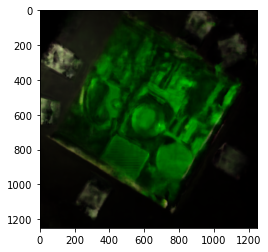

: 

In [12]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)


down = 1
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imsave('polaroid.png', img)
plt.imshow(img)
plt.show()

In [ ]:
down = 8 # trade off resolution+aliasing for render speed to make this video faster
frames = []
for i, c2w in enumerate(render_poses):
    if i%8==0: print(i)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
f = 'logs/fern_test/video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=8)

from IPython.display import Video
Video(f, height=320)

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np


def f(x, y, z):
    
    c2w = tf.convert_to_tensor([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda : widgets.FloatSlider(
    value=0.,
    min=-1.,
    max=1.,
    step=.01,
)

names = ['x', 'y', 'z']
    
interactive_plot = interactive(f, **{n : sldr() for n in names})
interactive_plot